In [14]:
#### kusto query public server

import pandas as pd
from azure.kusto.data import KustoClient, KustoConnectionStringBuilder, ClientRequestProperties
from azure.kusto.data.helpers import dataframe_from_result_table
from azure.kusto.data.exceptions import KustoServiceError
import traceback
import logging
import time

class KustoQuery(object):
    def __init__(self, **kwargs):        
        # self.client = None
        # self.kcsb = None
        # initialize client
        self.get_kusto_client()
        
    def get_kusto_client(self, **kwargs):
        import urllib3
        urllib3.disable_warnings()
    
        # self.cluster = kwargs.get('cluster', 'https://deepicm.westus2.kusto.windows.net')
        # self.cluster = 'https://msraaiops.eastus.kusto.windows.net'
        KustoCluster = 'https://cogsvc.kusto.windows.net/' #'https://msraaiops.eastus.kusto.windows.net'
        
        self.db = kwargs.get('database', 'Shared')#'WorkloadProfiling')
        self.db = 'Platform'
        # self.application_name = kwargs.get('application_name', "67862165-cbdc-4811-bb83-d6d945a98b6b")
        # self.AAD_tenant_id = kwargs.get('AAD_tenant_id', '72f988bf-86f1-41af-91ab-2d7cd011db47')     
   
        # self.application_name = kwargs.get('application_name', "549d2a15-4a98-4fee-becb-773e531b0f7c")
        # self.AAD_tenant_id = kwargs.get('AAD_tenant_id', '72f988bf-86f1-41af-91ab-2d7cd011db47')

        # ClientId = self.application_name
        # ClientSecret = self.application_pwd
        # AADTenantId = self.AAD_tenant_id
        
        # KustoCluster = self.cluster
        #kcsb = KustoConnectionStringBuilder.with_aad_device_authentication(KustoCluster) ### use this one to access via AAD
        kcsb = KustoConnectionStringBuilder.with_az_cli_authentication(KustoCluster)
        #kcsb = KustoConnectionStringBuilder.with_aad_application_key_authentication(KustoCluster, ClientId, ClientSecret, AADTenantId)
        kusto_client = KustoClient(kcsb)
        kusto_client._session.verify = False
        self.kcsb = kcsb
        self.client = kusto_client 
        
    def query(self, kql=None, return_type='dataframe'):
        if self.client is None:
            self.get_kusto_client()
        try:
            response = self.client.execute(self.db, kql)
            res = response.primary_results[0]
            if return_type == 'dataframe':
                return dataframe_from_result_table(res)
        except KustoServiceError as error:
            print("Error:",error)
            print('Retrying after sleeping for 10 sec..')
            #time.sleep(600)
            time.sleep(10)
            
            response = self.client.execute(self.db, kql)
            res = response.primary_results[0]
            if return_type == 'dataframe':
                return dataframe_from_result_table(res)
            else:
                return None
            # print("KustoServiceError: ", error)
            #logging.getLogger().warn(f'exception error = {error}, kql = {kql}')
            #logging.getLogger().warn(traceback.format_exc())
            #return None

In [15]:
query = """
set truncationmaxrecords = 1000000;
set truncationmaxsize=1048576000000;
let _startTime = datetime(2024-06-26T00:00:00Z);
let _endTime = datetime(2024-06-27T00:00:00Z);
let _regions = dynamic(['eastus', 'eastus2', 'centralus', 'northcentralus', 'southcentralus', 'westcentralus', 'westus', 'westus2', 'westus3']);
cluster('infraoptimization.westus2').database('workload').LLMApiRequestTracingEvent_Global
| where TIMESTAMP between (['_startTime'] .. ['_endTime'])
| where HttpResponseStatusCode == 200 and AOAIHttpResponseStatusCode == 200
| extend splitted = split(DeploymentName, '-')
| extend DeploymentRegion = tostring(splitted[0])
| extend ModelName = tostring(splitted[1])
| project-away splitted
| extend proddev = substring(ResolvedModelName, 0, indexof(ResolvedModelName, '-'))
| where DeploymentRegion in (_regions)
| where ScenarioName in (dynamic(['EnterpriseSydney']))
// | where proddev in (dynamic(['prod', 'dev']))
| where ModelName  in (dynamic(['gpt35turbo', 'gpt4']))
| project TIMESTAMP, AOAIRequestId, Tenant, ScenarioName, Deployments, ModelName, proddev
|join kind=inner(cluster('cogsvc').database('Platform').OpenAIBillingEvent
) on $left.AOAIRequestId == $right.['Request-Id']
| extend generatedT = parse_json(N_Generated_Tokens), contextT = parse_json(N_Context_Tokens), cachedT = parse_json(N_Context_Tokens_Cached) //, requestTime = unixtime_nanoseconds_todatetime(tolong(['Timestamp-Request-Engine']))
| extend generatedT = iff(generatedT == "[]", 0.0, array_sum(generatedT)), contextT = iff(contextT == "[]", 0.0, array_sum(contextT)), cachedT = iff(cachedT == "[]"  or isnull(cachedT), 0.0, array_sum(cachedT))
| extend token_size = generatedT
| extend prompt_size = cachedT +  contextT
| project TIMESTAMP, Tenant, ScenarioName, Deployments, ModelName, proddev, prompt_size, token_size
"""

In [16]:
kusto = KustoQuery()
df = kusto.query(kql=query)
df

KeyboardInterrupt: 

In [ ]:
pd.to_datetime(1719100800, unit='s')

Timestamp('2024-06-23 00:00:00')

In [ ]:
import pandas as pd
import datetime as dt


df['time'] = df['TIMESTAMP']
df['time'] = (df['time'].astype('int64')//1e6)/1000
mt = df['time'].min() // 1
df['time'] = df['time'] - mt
df['time'].min()

np.float64(0.6800000667572021)

In [ ]:
# request_id,batch_id,client_tenant,request_type,scenario,sla,utility,regions,model_type,workload_type,application_id,arrival_timestamp,batch_size,prompt_size,token_size
import random
request_id = -1
def translate_region(region):
    if 'eastus' in region:
        return '2'
    elif 'westus' in region:
        return '0'
    elif 'centralus' in region:
        return '1'
    else:
        return None
def get_regions(client):
    if client == '0':
        return '012' if random.random() < 0.5 else '021'
    elif client == '1':
        return '120' if random.random() < 0.5 else '102'
    elif client == '2':
        return '201' if random.random() < 0.5 else '210'
model_map = {'gpt4': 'llama2-70b', 'gpt35turbo': 'bloom-176b'}
with open('enterprise_sydney_26_dp.csv', 'w') as f:
    f.write('request_id,batch_id,client_tenant,request_type,scenario,sla,utility,regions,model_type,workload_type,application_id,arrival_timestamp,batch_size,prompt_size,token_size\n')
    for r in df.iterrows():
        request_id += 1
        batch_id = -1
        client_tenant = translate_region(r[1]['Tenant'])
        if client_tenant == None:
            continue
        request_type = 2
        scenario = r[1]['ScenarioName']
        sla = 10
        utility = 3 if r[1]['proddev'] == 'prod' else 1
        regions = r[1]['Deployments'].split(',')
        regions = get_regions(client_tenant)
        model_type = model_map[r[1]['ModelName']]
        workload_type = r[1]['proddev']
        model_type += '-d' if workload_type == 'dev' else '-p'
        workload_type = 'prod'
        application_id = -1
        arrival_timestamp = r[1]['time']
        batch_size = 1
        prompt_size = int(r[1]['prompt_size'])
        token_size = int(r[1]['token_size'])
        if prompt_size <= 0 or token_size <= 0:
            continue
        f.write(f'{request_id},{batch_id},{client_tenant},{request_type},{scenario},{sla},{utility},{regions},{model_type},{workload_type},{application_id},{arrival_timestamp},{batch_size},{prompt_size},{token_size}\n')
        # break
        # print(r[1]['prompt_size'], r[1]['token_size'])


In [3]:
r = pd.read_csv('/Users/shashwat/capalloc/traces/ES_26.csv')
r.sort_values(by='arrival_timestamp', inplace=True)
r.reset_index(drop=True, inplace=True)
r.loc[:, 'time_bucket'] = pd.cut(r['arrival_timestamp'], bins=range(0, int(r['arrival_timestamp'].max()) + 900, 900), right=False)
r = r.groupby('time_bucket', observed=False).agg({'request_id': lambda x : len(x)/900}).reset_index()
r

,time_bucket,request_id
0,"[0, 900)",4.700000
1,"[900, 1800)",5.638889
2,"[1800, 2700)",3.665556
3,"[2700, 3600)",3.747778
4,"[3600, 4500)",3.404444
...,...,...
91,"[81900, 82800)",5.288889
92,"[82800, 83700)",4.728889
93,"[83700, 84600)",5.907778
94,"[84600, 85500)",5.455556


In [25]:
import pandas as pd
feed_async = True
scaling_interval = 1800
# dfa = pd.read_csv('C:/Users/t-shjaiswal/simulator/results/0/enterprise_sydney/memory_async.csv')
df = pd.read_csv(f'/Users/shashwat/capalloc/results/0/ES_26/{feed_async}/scaling_interval_{scaling_interval}/memory.csv')
df.head()

,time,instance,memory,max_memory,util
0,1.259,westus_bloom-176b_0_0,3.290000e+11,1374389534720,0.239379
1,1.259,westus_bloom-176b_0_1,3.290000e+11,1374389534720,0.239379
2,1.259,westus_bloom-176b_0_2,3.290000e+11,1374389534720,0.239379
3,1.259,westus_bloom-176b_1_0,3.290000e+11,1374389534720,0.239379
4,1.259,westus_bloom-176b_1_1,3.290000e+11,1374389534720,0.239379


In [26]:
df['region_model'] = df['instance'].str[:-4]
df

,time,instance,memory,max_memory,util,region_model
0,1.259000,westus_bloom-176b_0_0,3.290000e+11,1374389534720,0.239379,westus_bloom-176b
1,1.259000,westus_bloom-176b_0_1,3.290000e+11,1374389534720,0.239379,westus_bloom-176b
2,1.259000,westus_bloom-176b_0_2,3.290000e+11,1374389534720,0.239379,westus_bloom-176b
3,1.259000,westus_bloom-176b_1_0,3.290000e+11,1374389534720,0.239379,westus_bloom-176b
4,1.259000,westus_bloom-176b_1_1,3.290000e+11,1374389534720,0.239379,westus_bloom-176b
...,...,...,...,...,...,...
2462164,89551.024589,eastus_bloom-176b_0_0,3.290000e+11,1374389534720,0.239379,eastus_bloom-176b
2462165,89551.024589,eastus_bloom-176b_0_1,3.290000e+11,1374389534720,0.239379,eastus_bloom-176b
2462166,89551.024589,eastus_llama2-70b_0_0,1.350000e+11,687194767360,0.196451,eastus_llama2-70b
2462167,89551.024589,eastus_llama2-70b_0_1,1.350000e+11,687194767360,0.196451,eastus_llama2-70b


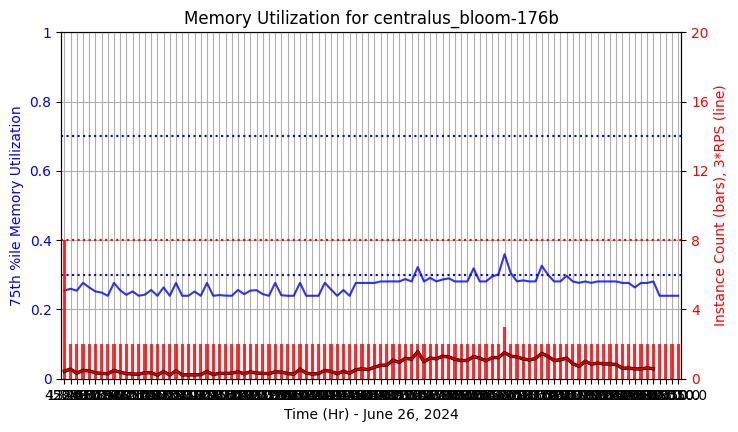

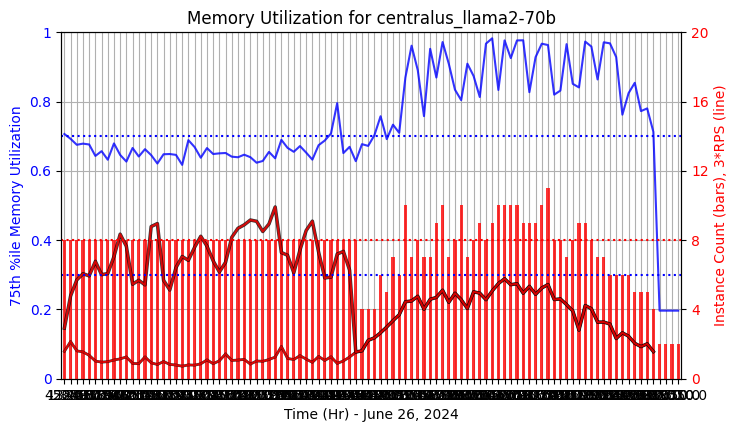

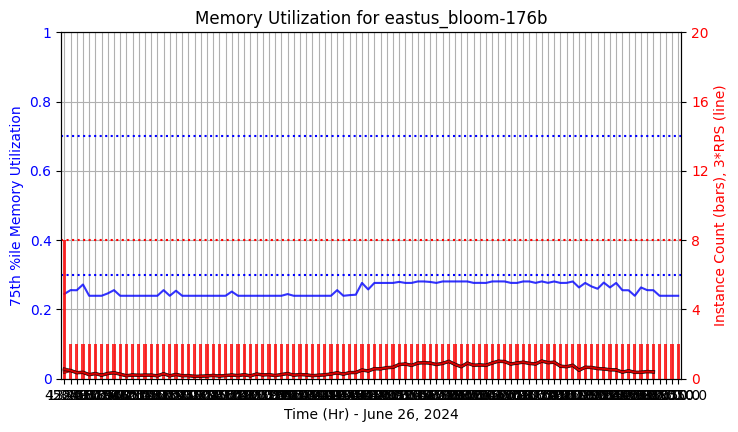

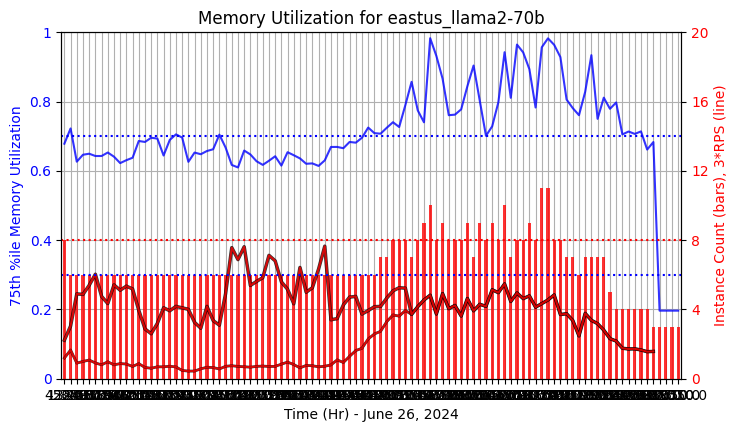

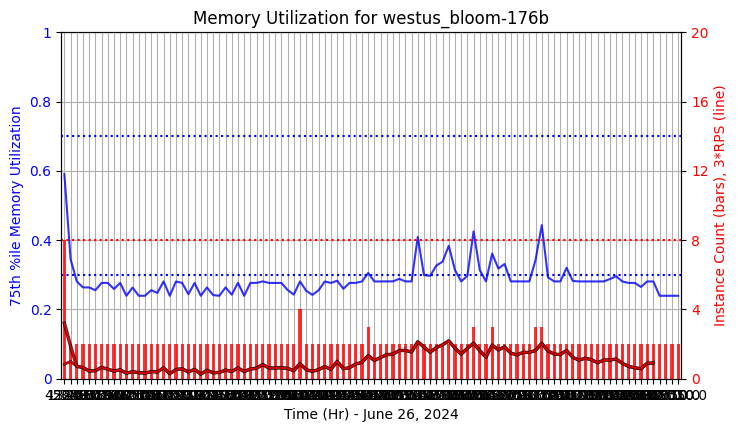

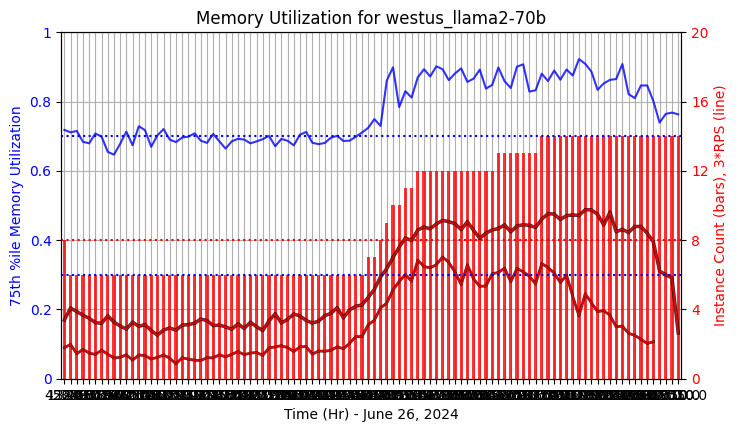

In [27]:
import matplotlib.pyplot as plt
for data in [df]:
    for region_model in sorted(list(set(data['region_model'].unique()))):
        region = region_model[:region_model.index('_')]
        model = region_model[region_model.index('_')+1:]
        region_router_file = f"/Users/shashwat/capalloc/results/0/ES_26/{feed_async}/region_routers/{region}.csv"
        rrdf = pd.read_csv(region_router_file)
        rrdf = rrdf[rrdf['model'] == model]
        rrdf_agg = rrdf.groupby('arrival_timestamp', observed=False).agg({'model': 'count'}).reset_index()
        rrdf_agg.loc[:, 'time_bucket'] = pd.cut(rrdf_agg['arrival_timestamp'], bins=range(0, int(rrdf_agg['arrival_timestamp'].max()) + 900, 900), right=False)
        rrdf_agg = rrdf_agg.groupby('time_bucket', observed=False).agg({'model': 'sum'}).reset_index()
        rrdf_agg['time_midpoint'] = rrdf_agg['time_bucket'].apply(lambda x: x.mid)
        rrdf_agg['model'] = rrdf_agg['model'] / 300

        # prod only
        rrdf = rrdf[rrdf['workload_type'] == 'prod']
        rrdf_agg_prod = rrdf.groupby('arrival_timestamp', observed=False).agg({'model': 'count'}).reset_index()
        rrdf_agg_prod.loc[:, 'time_bucket'] = pd.cut(rrdf_agg_prod['arrival_timestamp'], bins=range(0, int(rrdf_agg_prod['arrival_timestamp'].max()) + 900, 900), right=False)
        rrdf_agg_prod = rrdf_agg_prod.groupby('time_bucket', observed=False).agg({'model': 'sum'}).reset_index()
        rrdf_agg_prod['time_midpoint'] = rrdf_agg_prod['time_bucket'].apply(lambda x: x.mid)
        rrdf_agg_prod['model'] = rrdf_agg_prod['model'] / 300

        plt.figure(figsize=(8, 4.5), dpi=100)
        ax = plt.gca()
        d1 = data[data['region_model'] == region_model].copy()
        d1_agg = d1.groupby('time', observed=False).agg({'util': 'max', 'instance': lambda x: len(set(x))}).reset_index()
        
        # print(d1_agg)
        # break
        # d1_agg.columns = ['time_bucket', 'max_util', 'count']
        d1_agg.loc[:, 'time_bucket'] = pd.cut(d1_agg['time'], bins=range(0, int(d1_agg['time'].max()) + 900, 900), right=False)
        
        # print(d1)
        d1_agg = d1_agg.groupby('time_bucket', observed=False).agg({'util': lambda x: x.quantile(0.75), 'instance': 'max'}).reset_index()
        # d1_agg = d1_agg.merge(r, on='time_bucket', how='inner')
        
        # d1_agg = d1.groupby('time_bucket', observed=False)['util'].quantile(0.9).reset_index()
        d1_agg['time_midpoint'] = d1_agg['time_bucket'].apply(lambda x: x.mid)
        # print(d1_agg)

        ax2 = ax.twinx()
        d1_agg.plot(x='time_midpoint', y='instance', kind='bar', ax=ax2, color='red', alpha=0.8)
        ax2.set_ylabel('Instance Count (bars), 3*RPS (line)', color='red')
        # d1_agg.plot(x='time_midpoint', y='request_id', kind='line', ax=ax2, color='green', alpha=0.8)
        ax2.set_ylim(0, 20)
        ax2.set_yticks(range(0, 21, 4))
        ax2.set_yticklabels(range(0, 21, 4), color='red')

        # print(rrdf_agg_prod)
        rrdf_agg_prod.plot(x='time_midpoint', y='model', kind='line', ax=ax2, color='black', linewidth=2, alpha=0.8)
        rrdf_agg_prod.plot(x='time_midpoint', y='model', kind='line', ax=ax2, color='red', linewidth=1.5, alpha=0.8)

        # print(rrdf_agg)
        rrdf_agg.plot(x='time_midpoint', y='model', kind='line', ax=ax2, color='black', linewidth=2.5, alpha=0.8)
        rrdf_agg.plot(x='time_midpoint', y='model', kind='line', ax=ax2, color='red', linewidth=1.5, alpha=0.8)
        ax2.fill_between(x=rrdf_agg_prod['time_midpoint'], y1=0, y2=rrdf_agg_prod['model'], color='red', alpha=1)
        # ax2.legend(loc='upper right')

        d1_agg.plot(x='time_midpoint', y='util', kind='line', ax=ax, color='blue', alpha=0.8)
        ax2.fill_between(x=rrdf_agg_prod['time_midpoint'], y1=0, y2=1, color='red', alpha=1)
        # plt.legend()
        ax2.legend().set_visible(False)
        ax.legend().set_visible(False)
        plt.title(f'Memory Utilization for {region_model}')
        plt.axhline(y=8, color='red', linestyle='dotted')
        plt.axhline(y=14, color='blue', linestyle='dotted')
        plt.axhline(y=6, color='blue', linestyle='dotted')
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_ylabel('75th %ile Memory Utilization', color='blue')
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], color='blue')
        ax.set_xlabel('Time (Hr) - June 26, 2024')
        # ax.set_xticks(range(1, 25))
        # ax.set_xticklabels(range(1, 25))
        # ax.set_xticks(range(0, 25, 2))
        # ax.set_xlim(0, 86400)
        # ax.set_xticklabels(['' if i % 4 !=3 else i//4 + 1 for i in range(0, 97)])
        ax.grid(True)
        plt.show()
# plt.scatter(df['time'], df['util'])
# plt.xlabel('Time')
# plt.ylabel('Util')
# plt.title('Scatter Plot of Util vs Time')
# plt.show()

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_69298/4261763086.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend().set_visible(False)
/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_69298/4261763086.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().set_visible(False)


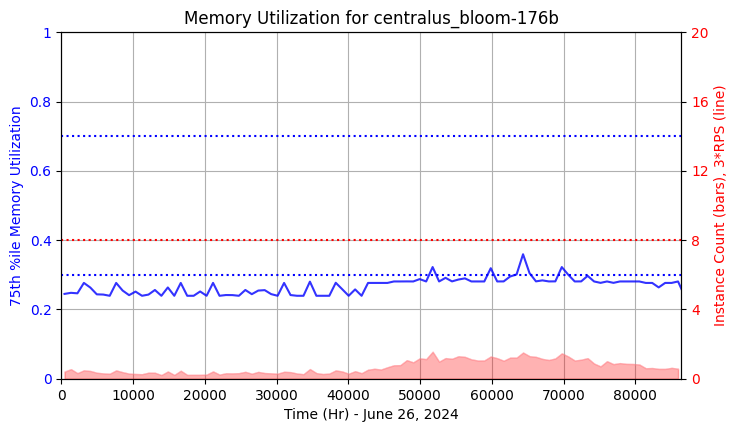

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_69298/4261763086.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend().set_visible(False)
/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_69298/4261763086.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().set_visible(False)


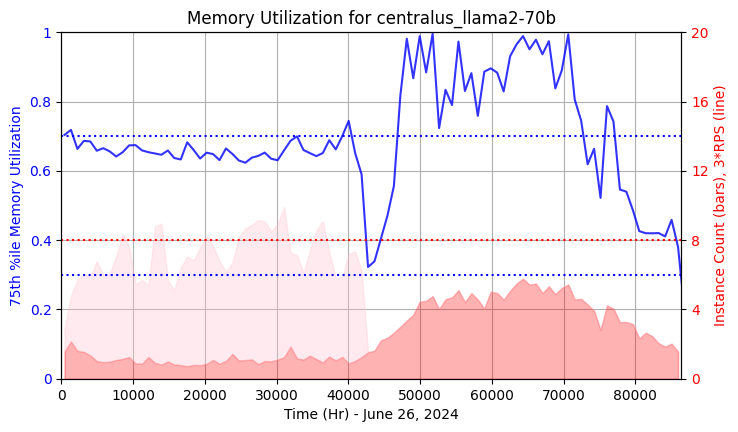

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_69298/4261763086.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend().set_visible(False)
/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_69298/4261763086.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().set_visible(False)


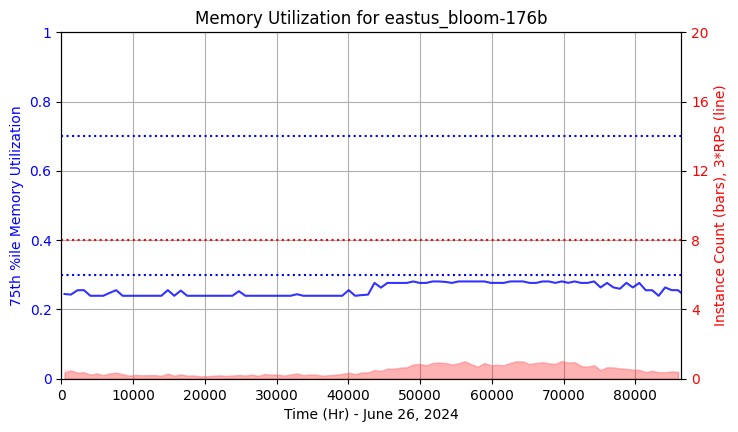

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_69298/4261763086.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend().set_visible(False)
/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_69298/4261763086.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().set_visible(False)


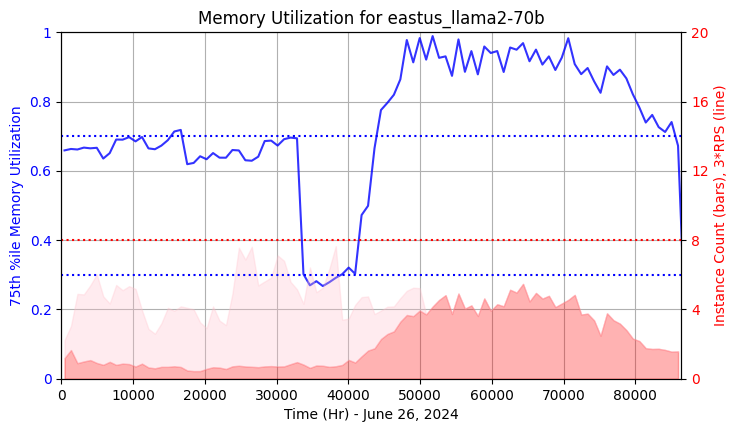

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_69298/4261763086.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend().set_visible(False)
/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_69298/4261763086.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().set_visible(False)


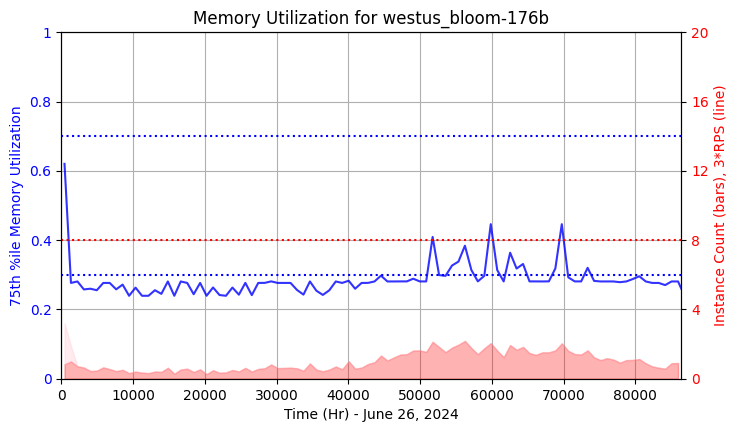

ValueError: operands could not be broadcast together with shapes (96,) (100,) 

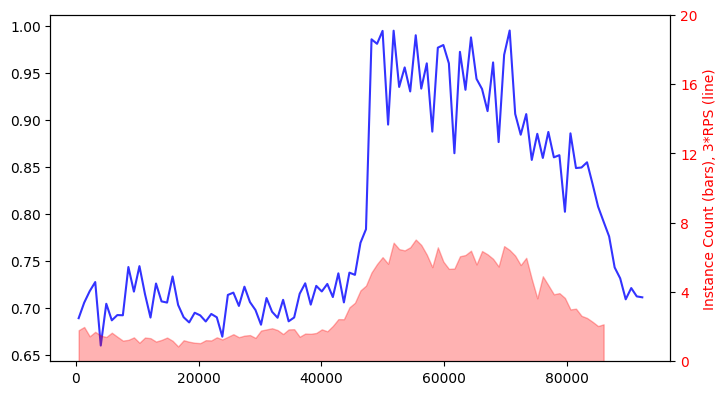

In [23]:
import matplotlib.pyplot as plt
for data in [df]:
    for region_model in sorted(list(set(data['region_model'].unique()))):
        region = region_model[:region_model.index('_')]
        model = region_model[region_model.index('_')+1:]
        region_router_file = f"/Users/shashwat/capalloc/results/0/ES_26/{feed_async}/region_routers/{region}.csv"
        rrdf = pd.read_csv(region_router_file)
        rrdf = rrdf[rrdf['model'] == model]
        rrdf_agg = rrdf.groupby('arrival_timestamp', observed=False).agg({'model': 'count'}).reset_index()
        rrdf_agg.loc[:, 'time_bucket'] = pd.cut(rrdf_agg['arrival_timestamp'], bins=range(0, int(rrdf_agg['arrival_timestamp'].max()) + 900, 900), right=False)
        rrdf_agg = rrdf_agg.groupby('time_bucket', observed=False).agg({'model': 'sum'}).reset_index()
        rrdf_agg['time_midpoint'] = rrdf_agg['time_bucket'].apply(lambda x: x.mid)
        rrdf_agg['model'] = rrdf_agg['model'] / 300

        # prod only
        rrdf = rrdf[rrdf['workload_type'] == 'prod']
        rrdf_agg_prod = rrdf.groupby('arrival_timestamp', observed=False).agg({'model': 'count'}).reset_index()
        rrdf_agg_prod.loc[:, 'time_bucket'] = pd.cut(rrdf_agg_prod['arrival_timestamp'], bins=range(0, int(rrdf_agg_prod['arrival_timestamp'].max()) + 900, 900), right=False)
        rrdf_agg_prod = rrdf_agg_prod.groupby('time_bucket', observed=False).agg({'model': 'sum'}).reset_index()
        rrdf_agg_prod['time_midpoint'] = rrdf_agg_prod['time_bucket'].apply(lambda x: x.mid)
        rrdf_agg_prod['model'] = rrdf_agg_prod['model'] / 300

        plt.figure(figsize=(8, 4.5), dpi=100)
        ax = plt.gca()
        d1 = data[data['region_model'] == region_model].copy()
        d1_agg = d1.groupby('time', observed=False).agg({'util': 'max', 'instance': lambda x: len(set(x))}).reset_index()
        
        # print(d1_agg)
        # break
        # d1_agg.columns = ['time_bucket', 'max_util', 'count']
        d1_agg.loc[:, 'time_bucket'] = pd.cut(d1_agg['time'], bins=range(0, int(d1_agg['time'].max()) + 900, 900), right=False)
        
        # print(d1)
        d1_agg = d1_agg.groupby('time_bucket', observed=False).agg({'util': lambda x: x.quantile(0.75), 'instance': 'max'}).reset_index()
        # d1_agg = d1_agg.merge(r, on='time_bucket', how='inner')
        
        # d1_agg = d1.groupby('time_bucket', observed=False)['util'].quantile(0.9).reset_index()
        d1_agg['time_midpoint'] = d1_agg['time_bucket'].apply(lambda x: x.mid)
        # print(d1_agg)

        ax2 = ax.twinx()
        plt.bar(x=d1_agg['time_midpoint'], height=d1_agg['instance']/20, color='red', alpha=0.8)
        ax2.set_ylabel('Instance Count (bars), 3*RPS (line)', color='red')
        # d1_agg.plot(x='time_midpoint', y='request_id', kind='line', ax=ax2, color='green', alpha=0.8)
        ax2.set_ylim(0, 20)
        ax2.set_yticks(range(0, 21, 4))
        ax2.set_yticklabels(range(0, 21, 4), color='red')
        
        # print(rrdf_agg_prod)
        # ax2.plot(rrdf_agg_prod['time_midpoint'], rrdf_agg_prod['model'], color='black', linewidth=2, alpha=0.8)
        # ax2.plot(rrdf_agg_prod['time_midpoint'], rrdf_agg_prod['model'], color='red', linewidth=1.5, alpha=0.8)

        # print(rrdf_agg)
        # ax2.plot(rrdf_agg['time_midpoint'], rrdf_agg['model'], color='black', linewidth=2.5, alpha=0.8)
        # ax2.plot(rrdf_agg['time_midpoint'], rrdf_agg['model'], color='red', linewidth=1.5, alpha=0.8)
        ax2.fill_between(x=rrdf_agg_prod['time_midpoint'], y1=0, y2=rrdf_agg_prod['model'], color='red', alpha=0.3)
        # ax2.legend(loc='upper right')

        ax.plot(d1_agg['time_midpoint'], d1_agg['util'], color='blue', alpha=0.8)
        ax2.fill_between(x=rrdf_agg_prod['time_midpoint'], y1=rrdf_agg_prod['model'], y2=rrdf_agg['model'], color='pink', alpha=0.3)
        # plt.legend()
        ax2.legend().set_visible(False)
        ax.legend().set_visible(False)
        plt.title(f'Memory Utilization for {region_model}')
        plt.axhline(y=8, color='red', linestyle='dotted')
        plt.axhline(y=14, color='blue', linestyle='dotted')
        plt.axhline(y=6, color='blue', linestyle='dotted')
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_ylabel('75th %ile Memory Utilization', color='blue')
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], color='blue')
        ax.set_xlabel('Time (Hr) - June 26, 2024')
        # ax.set_xticks(range(1, 25))
        # ax.set_xticklabels(range(1, 25))
        # ax.set_xticks(range(0, 25, 2))
        ax.set_xlim(0, 86400)
        # ax.set_xticklabels(['' if i % 4 !=3 else i//4 + 1 for i in range(0, 97)])
        ax.grid(True)
        plt.show()
# plt.scatter(df['time'], df['util'])
# plt.xlabel('Time')
# plt.ylabel('Util')
# plt.title('Scatter Plot of Util vs Time')
# plt.show()

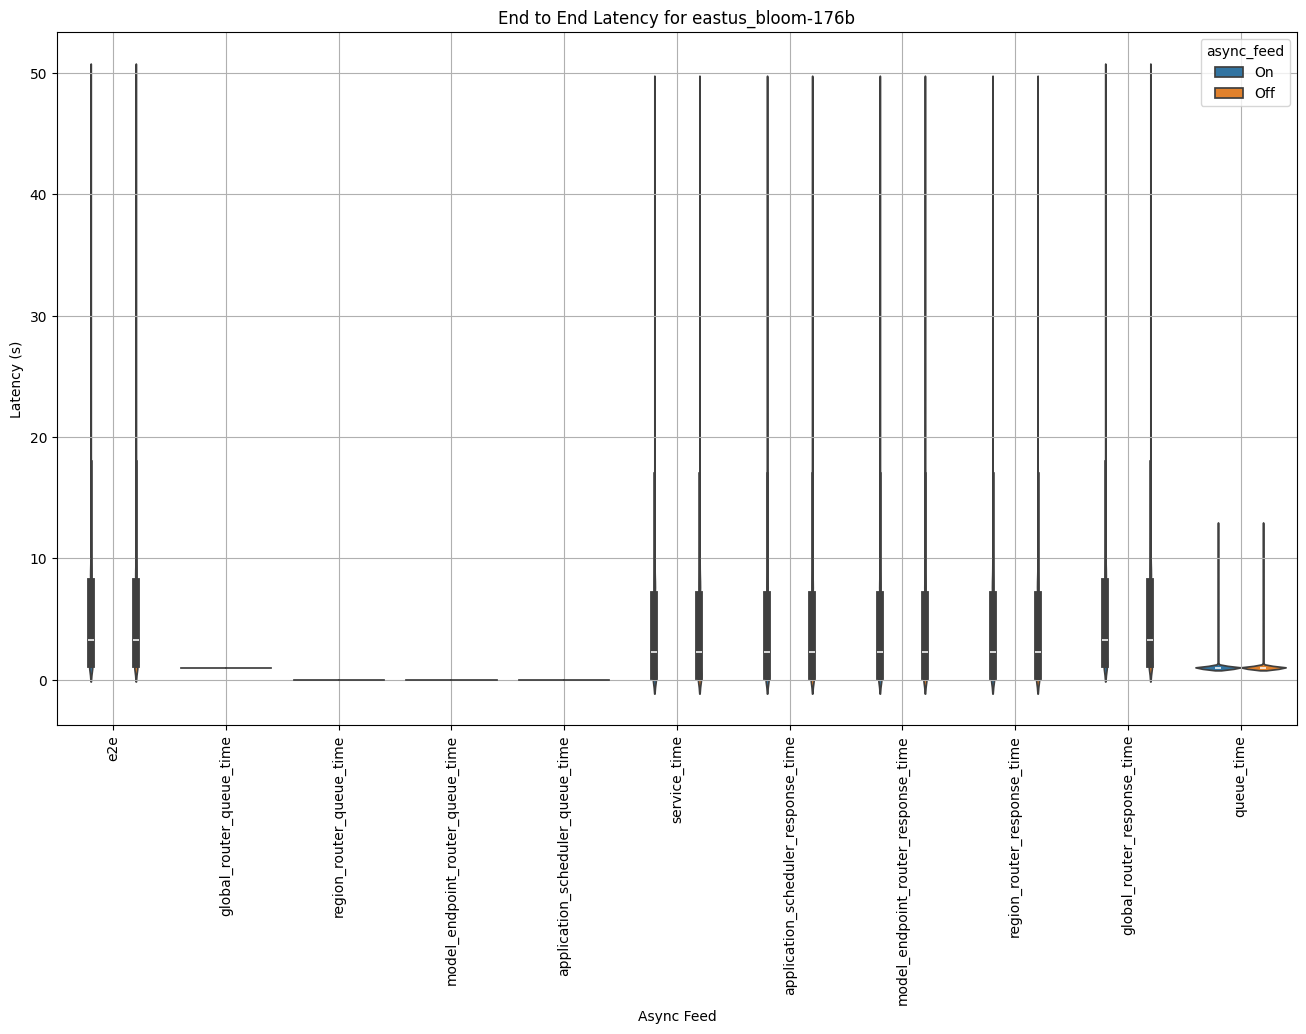

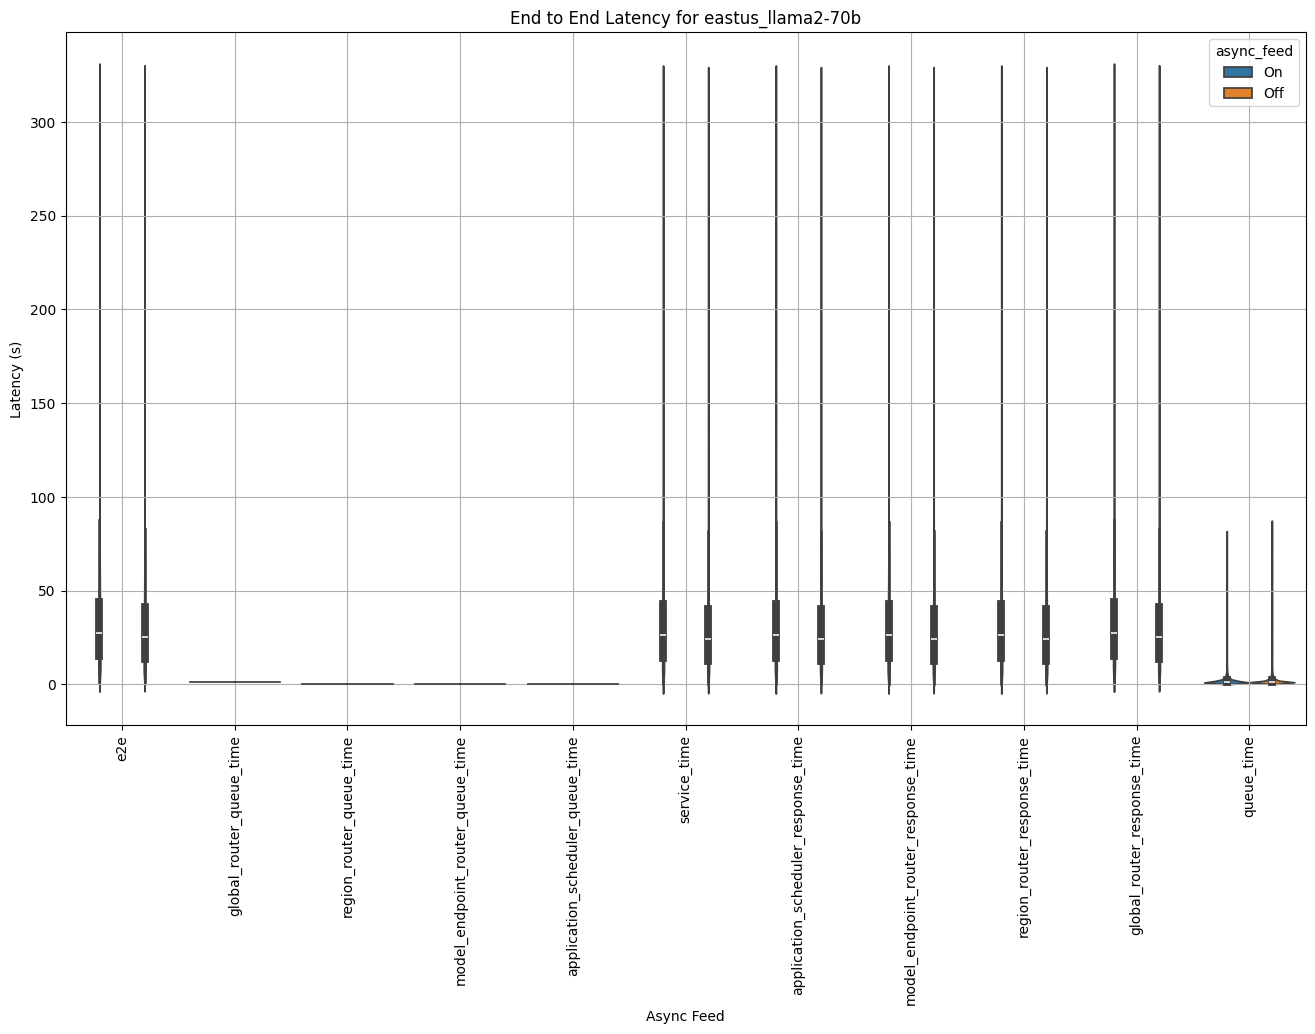

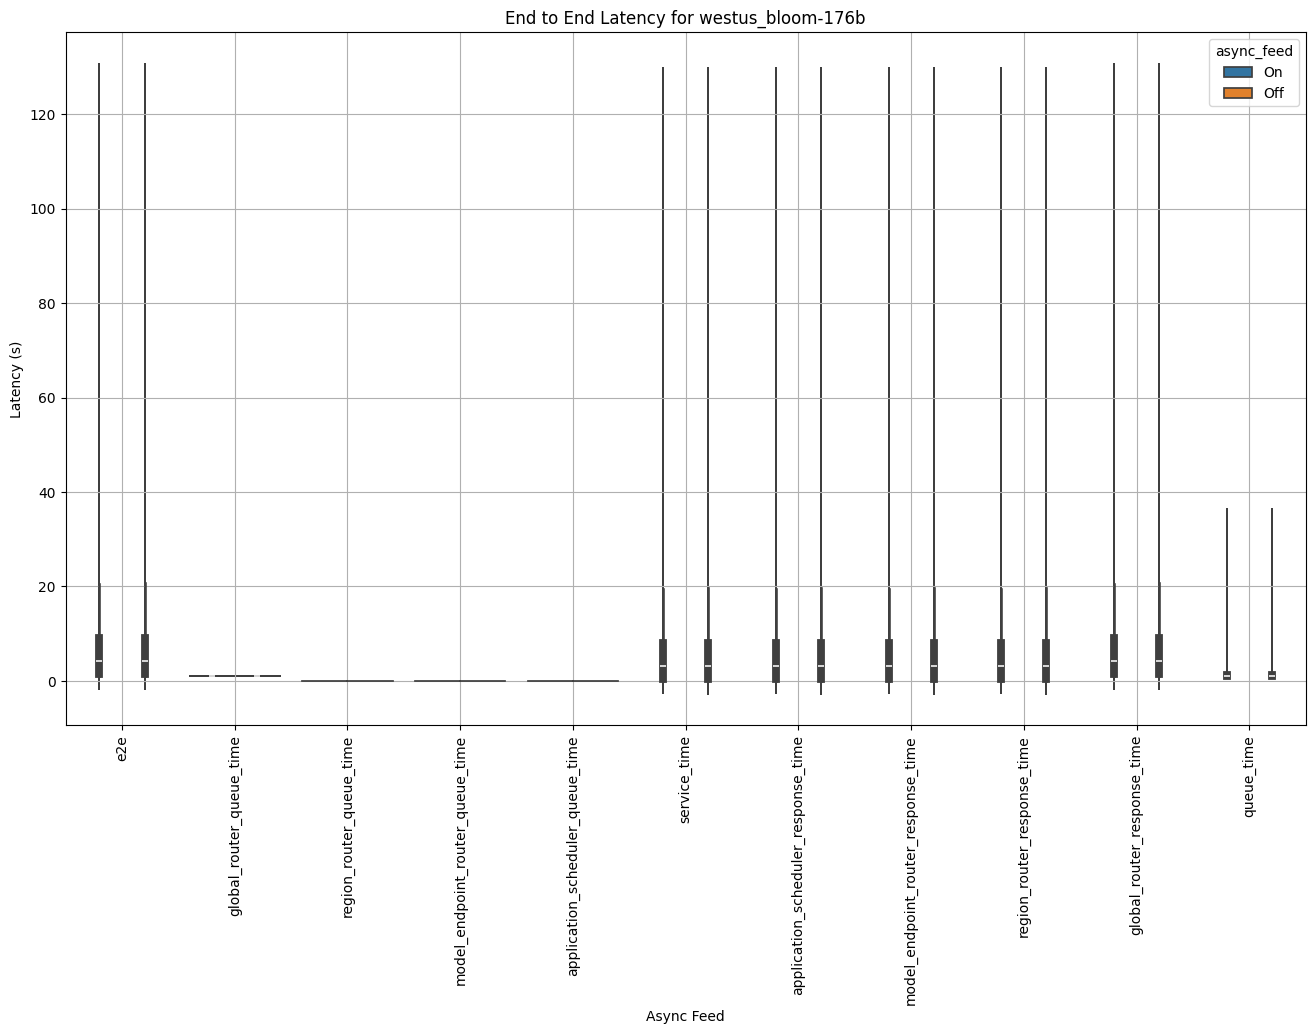

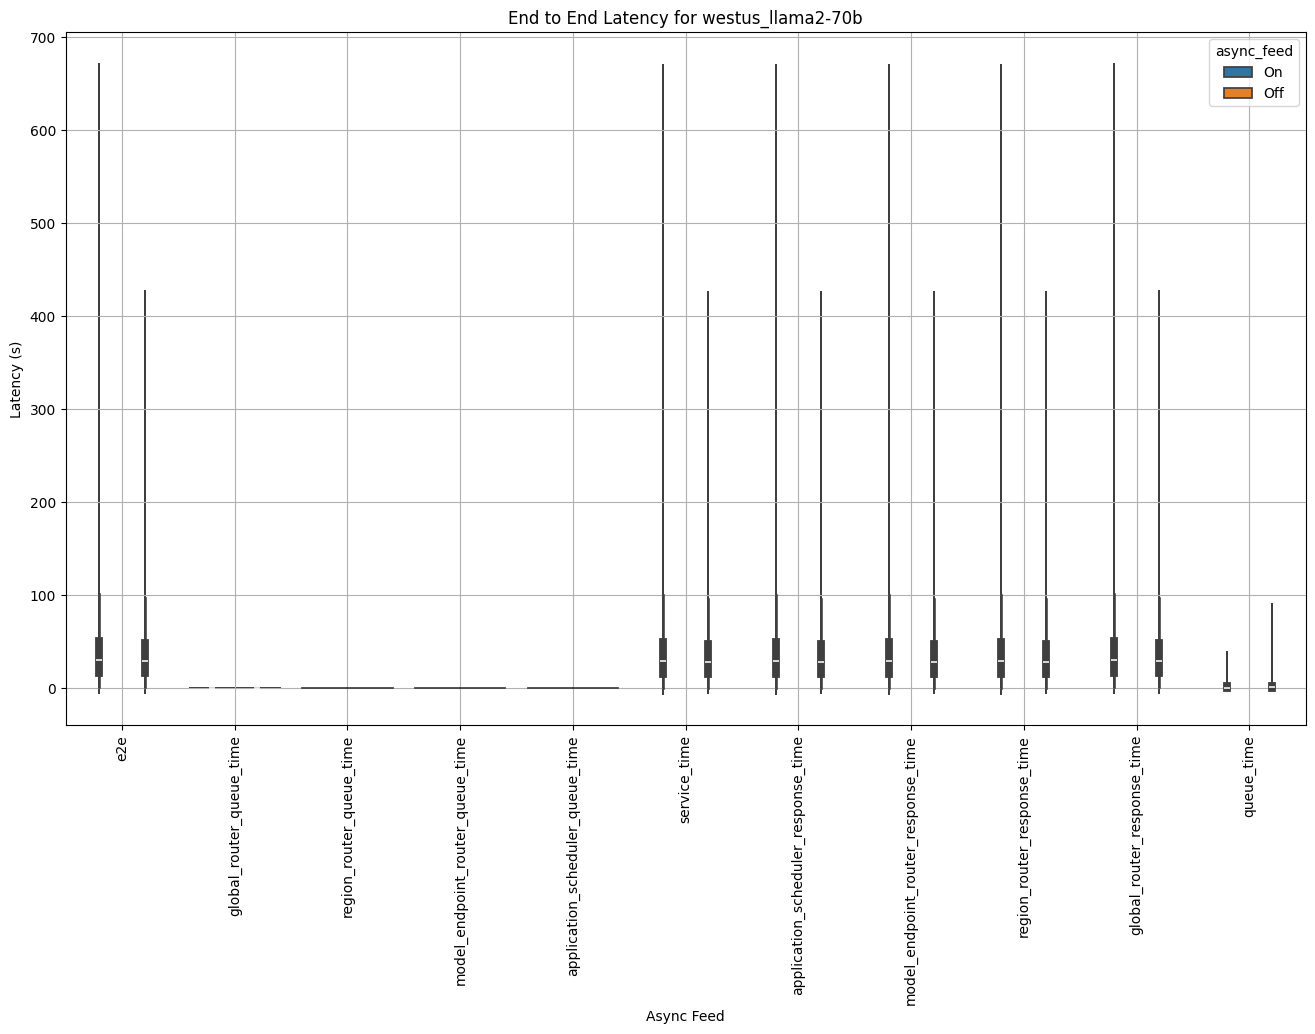

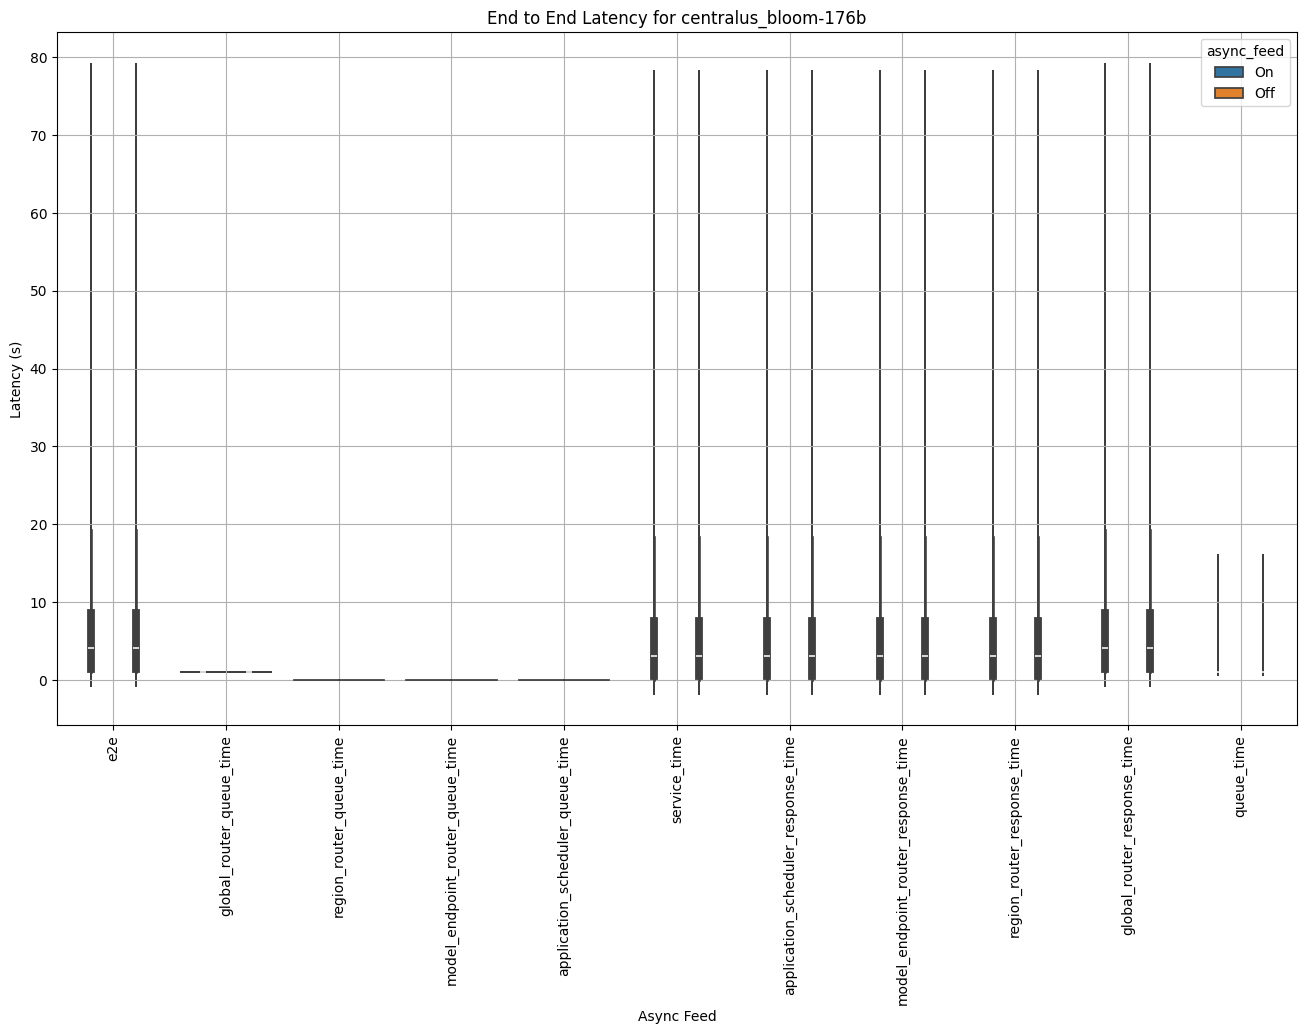

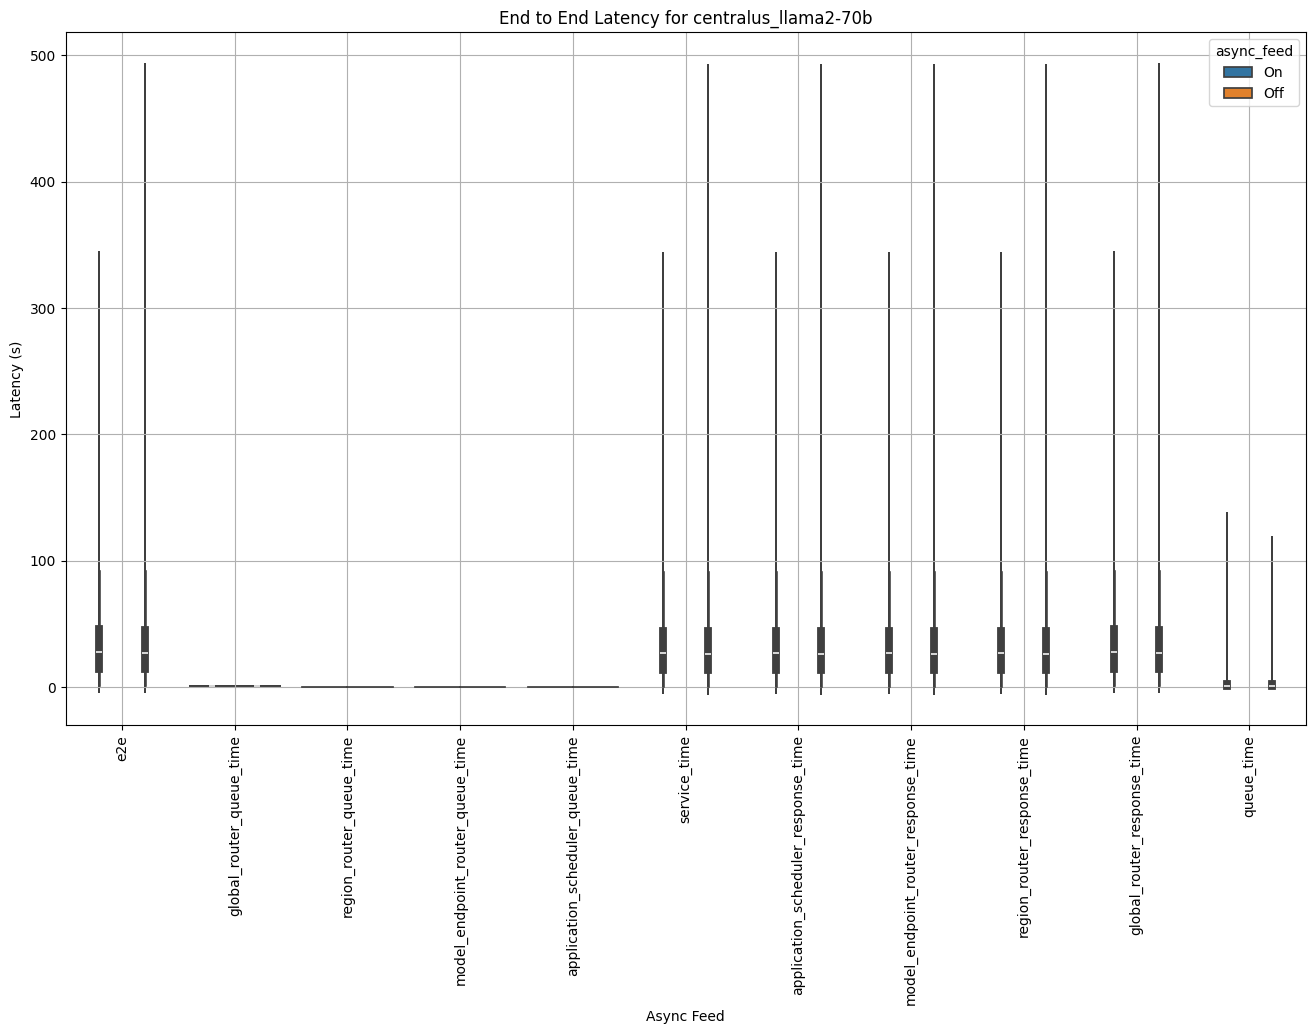

In [30]:
import seaborn as sns
for region in ['eastus', 'westus', 'centralus']:
    for model in ['bloom-176b', 'llama2-70b']:
        dfa = {'latency': [],
               'type':[],
               'async_feed': []}
        for async_feed in [True, False]:
            region_router_file = f"/Users/shashwat/capalloc/results/0/ES_26/{async_feed}/scaling_interval_1800/region_routers/{region}.csv"
            df = pd.read_csv(region_router_file)
            df = df[(df['model'] == model) & (df['workload_type'] == 'prod')]
            l = len(df)
            latency = df['completion_timestamp'] - df['arrival_timestamp']
            dfa['latency'].extend(list(latency))
            dfa['type'].extend(['e2e']*l)
            dfa['async_feed'].extend(["On" if async_feed else "Off" for _ in range(l)])
            for col in df.select_dtypes(include=['number']).columns:
                if col in ['request_id', 'arrival_timestamp', 'completion_timestamp']:
                    continue
                dfa['latency'].extend(df[col].tolist())
                dfa['async_feed'].extend(["On" if async_feed else "Off" for _ in range(l)])
                dfa['type'].extend([col]*l)
            
        df = pd.DataFrame(dfa)
        fig, ax = plt.subplots(figsize=(16, 9), dpi=100)

        # Using seaborn's violin plot with matplotlib's axis
        sns.violinplot(x='type', y='latency', hue='async_feed', data=df, ax=ax)
        ax.set_ylabel('Latency (s)')
        ax.set_xlabel('Async Feed')
        ax.set_title(f'End to End Latency for {region}_{model}')
        plt.xticks(rotation=90)
        # plt.ylim(0,20)
        plt.grid()
        plt.show()

In [158]:
for region in ["westus"]:
    for async_feed in [True, False]:
        path = f"/Users/shashwat/capalloc/results/0/ES_26/{async_feed}/arbiters/{region}.csv"
        df = pd.read_csv(region_router_file)
        
        

latency       bloom-176b
type               model
async_feed            On
Name: 312, dtype: object

/var/folders/nq/c_g89h2x3qj3kft5fdm_21m80000gn/T/ipykernel_89697/60644128.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grouped_df[['prod', 'spot']] = grouped_df[['prod', 'spot']].fillna(method='ffill')


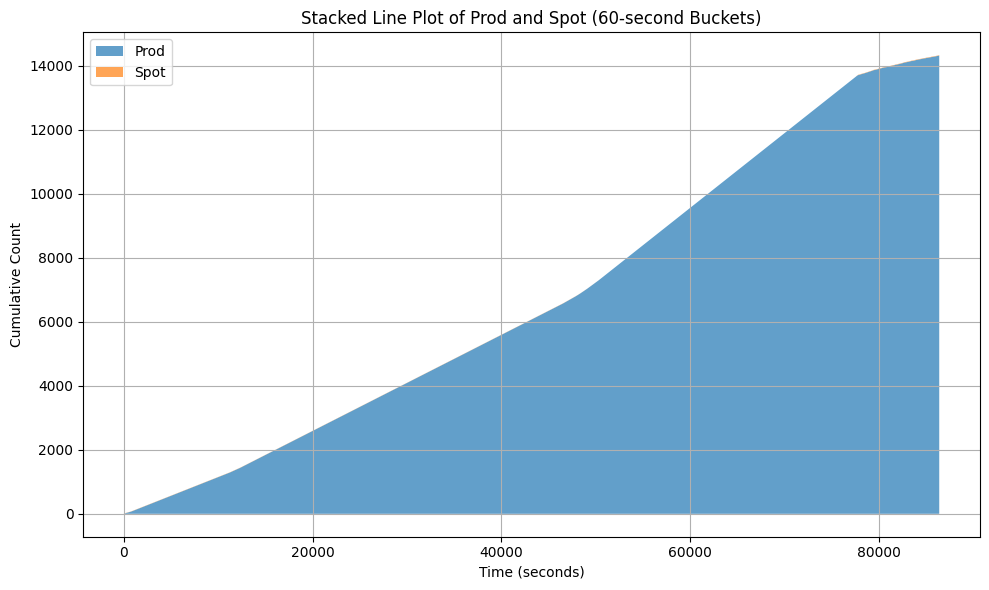

In [172]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('/Users/shashwat/capalloc/results/0/ES_26/True/arbiters/westus.csv')

# Ensure the columns are correctly typed
df['time'] = pd.to_numeric(df['timestamp'], errors='coerce')
df['prod'] = pd.to_numeric(df['prod'], errors='coerce')
df['spot'] = pd.to_numeric(df['spot'], errors='coerce')

# Group time into 60-second buckets (convert to integer floor values)
df['time_bucket'] = (df['time'] // 60).astype(int) * 60  # Bucket size of 60 seconds

# Get the max of 'prod' and 'spot' in each bucket
grouped_df = df.groupby('time_bucket')[['prod', 'spot']].max().reset_index()

# Generate a complete range of buckets
min_time, max_time = int(grouped_df['time_bucket'].min()), int(grouped_df['time_bucket'].max())
all_buckets = pd.DataFrame({'time_bucket': range(min_time, max_time + 60, 60)})

# Merge to ensure no missing buckets
grouped_df = pd.merge(all_buckets, grouped_df, on='time_bucket', how='left')

# Fill missing values with the previous bucket's values (forward fill)
grouped_df[['prod', 'spot']] = grouped_df[['prod', 'spot']].fillna(method='ffill')

# Calculate cumulative sums for the stacked plot
cumulative_prod = grouped_df['prod'].cumsum()
cumulative_spot = cumulative_prod + grouped_df['spot']

# Plot the stacked area plot using fill_between
plt.figure(figsize=(10, 6))

plt.fill_between(grouped_df['time_bucket'], cumulative_prod, label='Prod', alpha=0.7)
plt.fill_between(grouped_df['time_bucket'], cumulative_spot, cumulative_prod, label='Spot', alpha=0.7)

# Labeling and formatting
plt.xlabel('Time (seconds)')
plt.ylabel('Cumulative Count')
plt.title('Stacked Line Plot of Prod and Spot (60-second Buckets)')
plt.legend(loc='upper left')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()



In [92]:
!pip install seaborn

In [3]:
import os
os.path.exists("../results/0/day-1-dp/feed_async_True/feed_async_granularity_1/scaling_level_2/scaling_interval_-1/lts_False_stsTrue/")

True